In [2]:
import numpy as np
import tensorflow as tf
import os 
from tensorflow.keras import *
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from utils.callbacks import CustomCallback, step_decay_schedule
import json
import os
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
def load_mnist(x_train, y_train, x_test, y_test):
    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))
    return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test)= load_mnist(x_train, y_train, x_test, y_test)

In [6]:
class VariationalAutoencoder():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,decoder_conv_t_filters, decoder_conv_t_kernel_size, decoder_conv_t_strides, z_dim, use_batch_norm=False, use_dropout=False):
    
        self.name = 'variational_autoencoder'
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()
    
    def _build(self):
        
        ###ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)
                
        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        
        #Instead of connecting the flattened layer directly to the 2D latent space, we connect it to layers mu and log_var
        self.mu = Dense(self.z_dim, name='mu')(x) 
        self.log_var = Dense(self.z_dim, name='log_var')(x)
        
        #The Keras model that outputs the values of mu and log_var for a given input image
        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var)) 

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon
        
        #This Lambda layer samples a point z in the latent space from the normal distribution defined by the parameters mu and log_var.
        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])
        
    
        self.encoder = Model(encoder_input, encoder_output)
        
        ###DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ###FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)
        
        
    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss
            
        #KL divergence is a way of measuring how much one probability distribution differs from
        #another. In a VAE, we want to measure how different our normal distribution with parameters mu
        #and log_var is from the standard normal distribution.
        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])
        #we now have a well-defined distribution that we can use for choosing points in the latent
        #space—the standard normal distribution. If we sample from this distribution, we know that we’re
        #very likely to get a point that lies within the limits of what the VAE is used to seeing. Secondly,
        #since this term tries to force all encoded distributions toward the standard normal distribution,
        #there is less chance that large gaps will form between point clusters. Instead, the encoder will try
        #to use the space around the origin symmetrically and efficiently.

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        
        checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )



    def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

        self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                
        self.model.fit_generator(
            data_flow
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
            , steps_per_epoch=steps_per_epoch 
            )


    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

In [8]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [15]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [16]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 64)        0         
__________

In [17]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 80
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [18]:
with tf.device("gpu:0"):
    vae.train(     
        x_train
        , batch_size = BATCH_SIZE
        , epochs = EPOCHS
        , run_folder = RUN_FOLDER
        , print_every_n_batches = PRINT_EVERY_N_BATCHES
        , initial_epoch = INITIAL_EPOCH
    )

Epoch 1/80
60000/60000 [==============================] - 69s 1ms/step - loss: 53.6556 - vae_r_loss: 50.0600 - vae_kl_loss: 3.5956

Epoch 00001: saving model to run/vae/0002_digits/weights/weights-001-53.66.h5

Epoch 00001: saving model to run/vae/0002_digits/weights/weights.h5
Epoch 2/80
60000/60000 [==============================] - 72s 1ms/step - loss: 50.8791 - vae_r_loss: 46.7611 - vae_kl_loss: 4.1180

Epoch 00002: saving model to run/vae/0002_digits/weights/weights-002-50.88.h5

Epoch 00002: saving model to run/vae/0002_digits/weights/weights.h5
Epoch 3/80
60000/60000 [==============================] - 78s 1ms/step - loss: 49.6386 - vae_r_loss: 45.2801 - vae_kl_loss: 4.3585

Epoch 00003: saving model to run/vae/0002_digits/weights/weights-003-49.64.h5

Epoch 00003: saving model to run/vae/0002_digits/weights/weights.h5
Epoch 4/80
60000/60000 [==============================] - 75s 1ms/step - loss: 48.8882 - vae_r_loss: 44.3642 - vae_kl_loss: 4.5240

Epoch 00004: saving model to ru

60000/60000 [==============================] - 62s 1ms/step - loss: 44.3804 - vae_r_loss: 39.0986 - vae_kl_loss: 5.2819

Epoch 00059: saving model to run/vae/0002_digits/weights/weights-059-44.38.h5

Epoch 00059: saving model to run/vae/0002_digits/weights/weights.h5
Epoch 60/80
60000/60000 [==============================] - 62s 1ms/step - loss: 44.3411 - vae_r_loss: 39.0509 - vae_kl_loss: 5.2902

Epoch 00060: saving model to run/vae/0002_digits/weights/weights-060-44.34.h5

Epoch 00060: saving model to run/vae/0002_digits/weights/weights.h5
Epoch 61/80
60000/60000 [==============================] - 62s 1ms/step - loss: 44.3703 - vae_r_loss: 39.0717 - vae_kl_loss: 5.2986

Epoch 00061: saving model to run/vae/0002_digits/weights/weights-061-44.37.h5

Epoch 00061: saving model to run/vae/0002_digits/weights/weights.h5
Epoch 62/80
60000/60000 [==============================] - 62s 1ms/step - loss: 44.3243 - vae_r_loss: 39.0262 - vae_kl_loss: 5.2981

Epoch 00062: saving model to run/vae/00

In [19]:
def load_model(model_class, folder):
    
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model

In [20]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

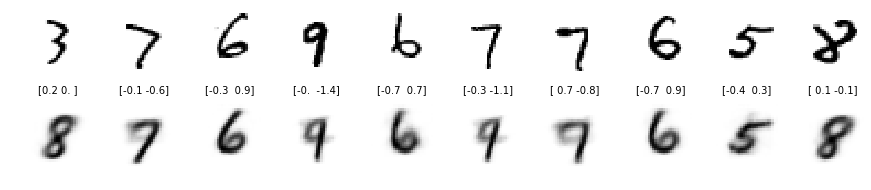

In [23]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

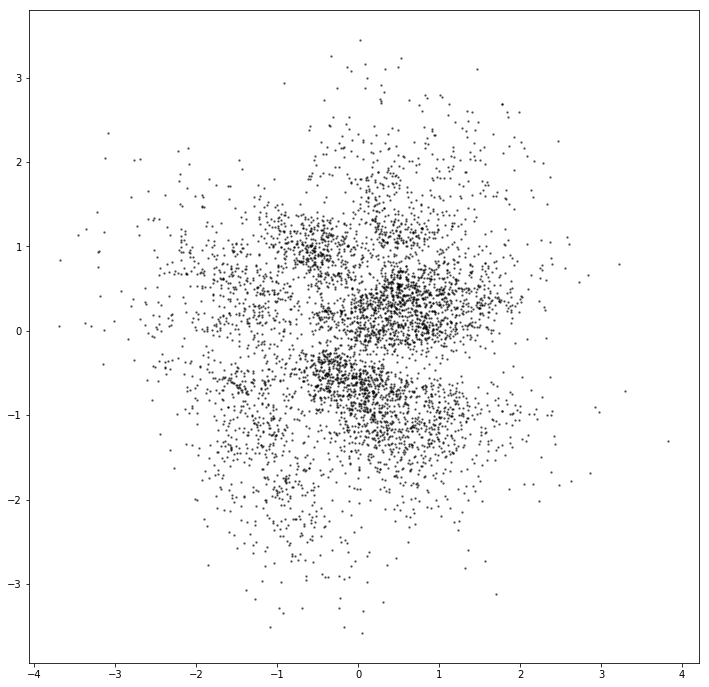

In [24]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

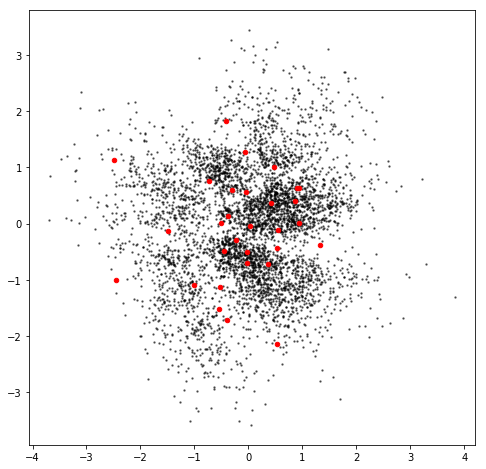

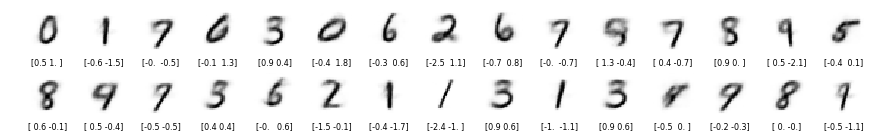

In [25]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

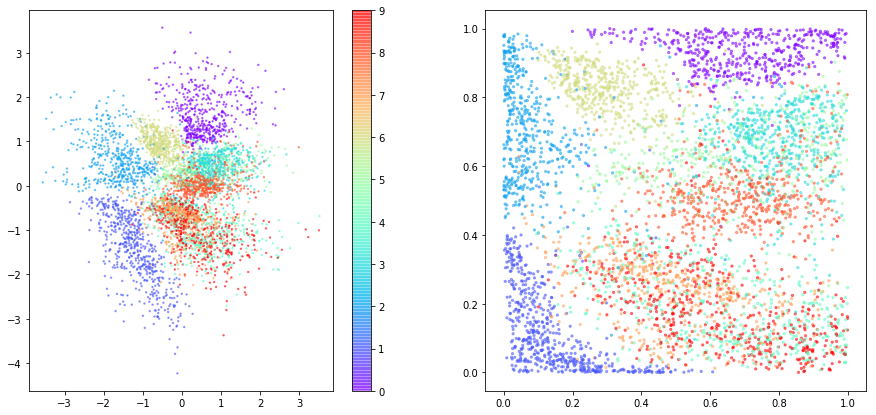

In [27]:
from scipy.stats import norm
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

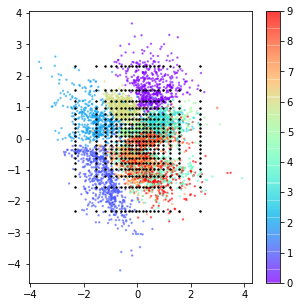

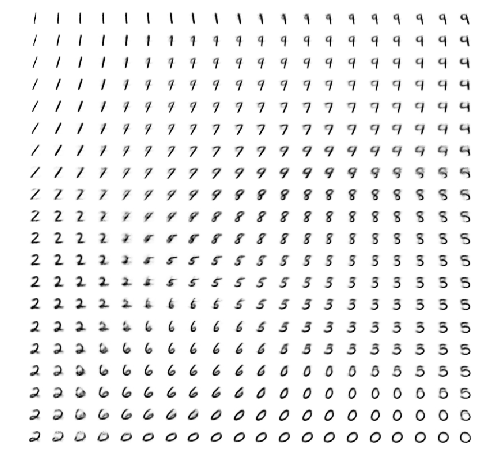

In [29]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')